# Download and Unpack Data

In [1]:
import os
import pandas as pd
from keras.preprocessing import image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from glob import glob

In [4]:
#setup environment for API token so we can use kaggle api to download dataset


os.environ["KAGGLE_KEY"] = 'b8d84fede56341cc386a8916cac3982c'



In [3]:
#Download cancer detection dataset
!kaggle competitions download -c histopathologic-cancer-detection

100%|██████████████████████████████████████| 6.31G/6.31G [32:36<00:00, 2.06MB/s]
100%|██████████████████████████████████████| 6.31G/6.31G [32:36<00:00, 3.46MB/s]


In [25]:
#to permenently save checkpoints
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir data
!unzip -n histopathologic-cancer-detection.zip -d data

# Exploring Data

In [5]:
!ls data

sample_submission.csv  test  train  train_labels.csv


In [6]:
print("Number of training images:",len(os.listdir('data/test/')))
print("Number of test images:", len(os.listdir('data/train/')))

Number of training images: 57458
Number of test images: 220025


In [15]:
train_labels = pd.read_csv('data/train_labels.csv')
train_labels.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [8]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [9]:
train_labels.head()
train_labels.tail()

,id,label
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0
220024,a81f84895ddcd522302ddf34be02eb1b3e5af1cb,1


In [10]:
# read the image

def display_img(file):
  img = cv2.imread(file)
# format it to be in the RGB colorspace
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
# resize to 300x300 and normalize pixel values to be in the range [0, 1]
  img = cv2.resize(img, (300, 300)) / 255.0
  #img = img / 255.0
  #preview the image
  plt.figure(figsize=(2, 2))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

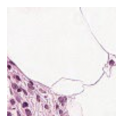

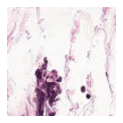

In [11]:
file_negative = 'data/train/f38a6374c348f90b587e046aac6079959adf3835.tif'
file_positive = 'data/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif'
display_img(file_negative)
display_img(file_positive)


# Build Tensorflow Data Generator for Training

In [22]:
!mkdir temp
!cp data/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif temp
!cp data/train/f38a6374c348f90b587e046aac6079959adf3835.tif temp

In [16]:

train_path = 'temp'
pattern = os.path.join(train_path,'*.tif')
glob(pattern)

['temp/f38a6374c348f90b587e046aac6079959adf3835.tif',
 'temp/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif']

In [17]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
df.head()

,path
0,temp/f38a6374c348f90b587e046aac6079959adf3835.tif
1,temp/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif


In [2]:
get_file_name_from_path = lambda x: (x.split('/')[-1])
extract_imgID_from_file_path = lambda x: (get_file_name_from_path(x).split('.')[0])
#extract_imgID_from_file_path('temp/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif')
#-> c18f2d887b7ae4f6742ee445113fa1aef383ed77

In [19]:
df['id'] = df.path.map(extract_imgID_from_file_path)

In [20]:
df

,path,id
0,temp/f38a6374c348f90b587e046aac6079959adf3835.tif,f38a6374c348f90b587e046aac6079959adf3835
1,temp/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,c18f2d887b7ae4f6742ee445113fa1aef383ed77


In [21]:
df = df.merge(train_labels, on = "id")
df['label'] = df['label'].astype(str)

In [22]:
df

,path,id,label
0,temp/f38a6374c348f90b587e046aac6079959adf3835.tif,f38a6374c348f90b587e046aac6079959adf3835,0
1,temp/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1


In [23]:
TRAINING_DIR = "data/train/"
VALIDATION_SPLIT = 0.02

df = pd.DataFrame({'path': glob(os.path.join(TRAINING_DIR,'*.tif'))})
df['id'] = df.path.map(extract_imgID_from_file_path)
df = df.merge(train_labels, on = "id")
df['label'] = df['label'].astype(str)

datagen = ImageDataGenerator(rescale=1./255,
    vertical_flip=True,
    horizontal_flip=True,
    rotation_range=10,
    brightness_range=(0.8, 1.2),
    channel_shift_range=16,
    zoom_range=0.1, 
    validation_split=VALIDATION_SPLIT)

train_generator = datagen.flow_from_dataframe(
    dataframe=df, 
    directory=None,
    x_col='path', 
    y_col='label',
    target_size=(112, 112),
    # classes=[0, 1],
    class_mode="binary",
    batch_size=64,
    subset='training')

validation_generator = datagen.flow_from_dataframe(
    dataframe=df, 
    directory=None,
    x_col='path', 
    y_col='label',
    target_size=(112, 112),
    # classes=[0, 1],
    class_mode="binary",
    batch_size=64,
    subset='validation')
images_test, labels_test = next(train_generator)
print(images_test.dtype, images_test.shape)
print(labels_test.dtype, labels_test.shape)



Found 215625 validated image filenames belonging to 2 classes.
Found 4400 validated image filenames belonging to 2 classes.
float32 (64, 112, 112, 3)
float32 (64,)


In [11]:
# ds = tf.data.Dataset.from_generator(
#     lambda: train_generator,
#     output_types=images_test.dtype,
#     output_shapes=images_test.shape)
# ds.element_spec

# Build the Model

In [12]:
strategy = tf.distribute.MirroredStrategy()

def feature_extractor_ResNet50(inputs):
  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224,
                                                                         224, 3),
  include_top=False,
  weights='imagenet')(inputs)
  return feature_extractor

def feature_extractor_MobileNet(inputs):
  feature_extractor = tf.keras.applications.MobileNetV3Large(input_shape=(224,
                                                                         224, 3),
  include_top=False,
  weights='imagenet')(inputs)
  return feature_extractor

def classifier(inputs):
  x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation="relu")(x)
  x = tf.keras.layers.Dense(512, activation="relu")(x)
  x = tf.keras.layers.Dense(1, activation="sigmoid", name="classification")(x)
  return x

def cancer_detector(inputs):
  resize = tf.keras.layers.UpSampling2D(size=(2, 2))(inputs)
  resnet_feature_extractor = feature_extractor_ResNet50(resize)
  classification_output = classifier(resnet_feature_extractor)
  return classification_output
  
def build_model():
  inputs = tf.keras.layers.Input(shape=(112,112,3))
  classification_output = cancer_detector(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics = ['accuracy'])
  return model 

with strategy.scope():
  model = build_model()
model.summary()

2022-04-09 22:51:17.262035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 22:51:17.262279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 22:51:17.269132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 22:51:17.269363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 22:51:17.269557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

# Training

In [13]:
EPOCHS = 5

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints',
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(train_generator, epochs=EPOCHS, batch_size=64,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    callbacks=[early_stop, checkpoint])
model.save('model')

# To load the model back:
# from tensorflow import keras
# model = keras.models.load_model('model')

# To restore weights only:
#checkpoint = tf.train.Checkpoint(model)
#checkpoint.restore('checkpoints/training_checkpoints-1')

2022-04-09 22:52:08.467262: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_12527"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key

Epoch 1/5
INFO:tensorflow:batch_all_reduce: 218 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 218 all-reduces with algorithm = nccl, num_packs = 1


2022-04-09 22:52:33.269683: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-04-09 22:52:33.451614: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


3370/3370 [==============================] - ETA: 0s - loss: 0.2726 - accuracy: 0.8907

2022-04-09 23:32:37.137846: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_71597"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:28"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  ke

3370/3370 [==============================] - 2499s 733ms/step - loss: 0.2726 - accuracy: 0.8907 - val_loss: 0.3875 - val_accuracy: 0.8798
Epoch 2/5
3370/3370 [==============================] - 2418s 717ms/step - loss: 0.2032 - accuracy: 0.9229 - val_loss: 0.4339 - val_accuracy: 0.8143
Epoch 3/5
3370/3370 [==============================] - 2470s 733ms/step - loss: 0.1798 - accuracy: 0.9332 - val_loss: 0.2839 - val_accuracy: 0.8818
Epoch 4/5
3370/3370 [==============================] - 2476s 735ms/step - loss: 0.1631 - accuracy: 0.9402 - val_loss: 0.5494 - val_accuracy: 0.8327
Epoch 5/5
3370/3370 [==============================] - 2432s 722ms/step - loss: 0.1568 - accuracy: 0.9429 - val_loss: 0.1829 - val_accuracy: 0.9336


2022-04-10 02:17:19.166929: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/assets


# Evaluation

In [41]:
from tensorflow import keras
model = keras.models.load_model('model')

2022-04-11 23:48:37.344258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 23:48:37.344467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 23:48:37.427728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 23:48:37.428348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 23:48:37.428878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [ ]:
result = model.evaluate(validation_generator, batch_size=128)

# Prediction
## Prepare Test Data

In [42]:
test_path = 'data/test'

datagen_test = ImageDataGenerator(rescale=1./255)

#if shuffle=False, data is sorted in alphanumeric order
test_generator = datagen_test.flow_from_directory(
    directory='data/test',
    target_size=(112, 112),
    class_mode=None,
    batch_size=64,
    shuffle=False)

Found 57458 images belonging to 1 classes.


## Start Prediction

In [43]:
test_result = model.predict(test_generator)

2022-04-11 23:49:12.034891: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


In [44]:
test_result.shape

(57458, 1)

In [ ]:
test_result1 = (test_result > 0.5).astype(int)
test_result1[5:]
#np.savetxt('test_result1', test_result1)

In [50]:
import pandas as pd
extract_imgID_from_file_path = lambda x: (x.split('.')[0])
df_my = pd.DataFrame(sorted(os.listdir('data/test/test1')))
df_my.columns=['id']
df_my['id'] = df_my.id.map(extract_imgID_from_file_path)

In [51]:
df2 = pd.DataFrame(test_result1)
df2.columns=['label']
df3 = pd.concat([df_my, df2], axis=1)
df3.to_csv('submission.csv', index=False)

# Plot Charts

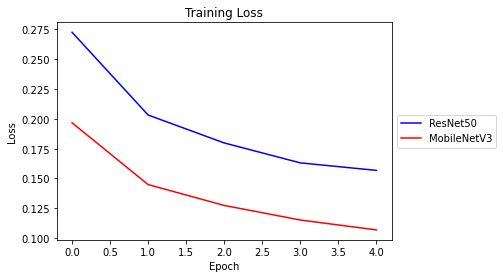

In [52]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

Epochs_x = [0,1,2,3,4]
ResNet50_time = [0.2726,0.2032,0.1798,0.1631,0.1568]
MobileNetV3_time = [0.1967,0.1449,0.1274,0.1152,0.1069]
fig, ax = plt.subplots()
ax.plot(Epochs_x, ResNet50_time, color='blue',label='ResNet50')
ax.plot(Epochs_x, MobileNetV3_time, color='red',label='MobileNetV3')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

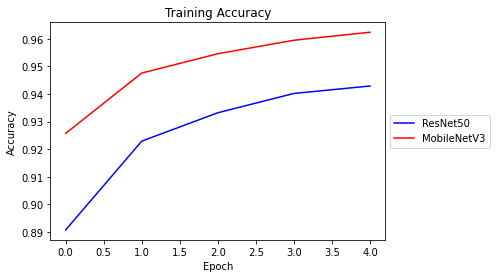

In [53]:
Epochs_x = [0,1,2,3,4]
ResNet50_time = [0.8907,0.9229,0.9332,0.9402,0.9429]
MobileNetV3_time = [0.9257,0.9476,0.9546,0.9595,0.9624]

fig, ax = plt.subplots()
ax.plot(Epochs_x, ResNet50_time, color='blue',label='ResNet50')
ax.plot(Epochs_x, MobileNetV3_time, color='red',label='MobileNetV3')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training Accuracy')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

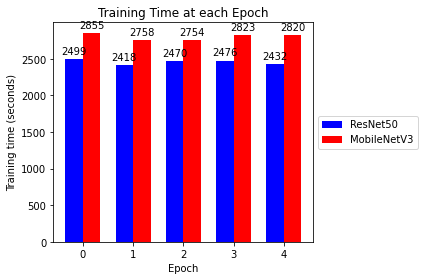

In [54]:
import numpy as np

Epochs_x = [0,1,2,3,4]
ResNet50_time = [2499,2418,2470,2476,2432]
MobileNetV3_time = [2855,2758,2754,2823,2820]
x = np.arange(len(Epochs_x))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ResNet50_time, width, label='ResNet50', color='blue')
rects2 = ax.bar(x + width/2, MobileNetV3_time, width, label='MobileNetV3', color='red')
ax.set_ylabel('Training time (seconds)')
ax.set_xlabel('Epoch')
ax.set_title('Training Time at each Epoch')
ax.set_xticks(x, Epochs_x)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

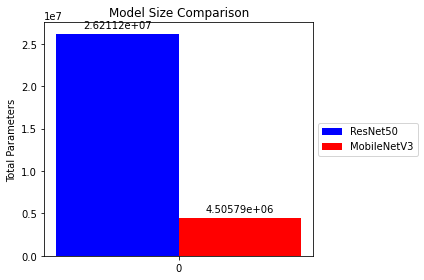

In [55]:
Epochs_x = [0]
ResNet50_time = [26211201]
MobileNetV3_time = [4505792]
x = np.arange(len(Epochs_x))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ResNet50_time, width, label='ResNet50', color='blue')
rects2 = ax.bar(x + width/2, MobileNetV3_time, width, label='MobileNetV3', color='red')
ax.set_title('Model Size Comparison')
ax.set_xticks(x, Epochs_x)
ax.set_ylabel('Total Parameters')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()